<a href="https://colab.research.google.com/github/guillermodangelo/tesis/blob/master/0_0_data_wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carga librerias

In [11]:
!pip install geopandas

In [0]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from google.colab import drive

import requests
import urllib
import json

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [140]:
# monta google drive y carga data desde allí
drive.mount("/content/drive")
!ls "drive/My Drive/bases_tesis/"
os.chdir('drive/My Drive/bases_tesis/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
df_distancias_google.csv  matrix.csv
export_prueba.csv	  personas_censo_2011.zip


In [0]:
# carga data de GitHub

# Datos censales
censo = pd.read_csv('https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/personas_censo_2011.zip', compression='zip', header=0, sep=',', quotechar='"')
print('Personas en Censo INE 2011: ', censo.shape[0])
print('Variables en Censo INE 2011: ', censo.shape[1])

# PBI departamental
pbi = pd.read_csv('https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/pbi_departamental.csv')

# matriz de distancias
capitales_md = pd.read_csv('https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/df_distancias_google.csv')

# carga capa localidades INE pt
localidad = gpd.read_file('https://raw.githubusercontent.com/guillermodangelo/tesis/master/capas/ine_localidades.gpkg')
localidad.CODLOC = localidad.CODLOC.astype(int)
print('Localidades en la capa INE: ', localidad.CODLOC.unique().shape[0])

# filtra capitales departamentales de las localidades INE
capital = localidad[localidad.CAPITAL==True].reset_index(drop=True)

Personas en Censo INE 2011:  3285877
Variables en Censo INE 2011:  26
Localidades en la capa INE:  615


In [53]:
# recupera el depto de la matriz de distancias
capital_cods = capital[['DEPTO','CODLOC']]

deptos_md = pd.merge(capitales_md, capital_cods, left_on='cod_ori', right_on='CODLOC')
deptos_md = pd.merge(deptos_md, capital_cods, left_on='cod_des', right_on='CODLOC')

deptos_md.rename(columns={'DEPTO_x': 'depto_ori', 'DEPTO_y': 'depto_des'}, inplace=True)
deptos_md.drop(['latlon_ori', 'latlon_des', 'cod', 'CODLOC_x', 'CODLOC_y'], axis=1, inplace=True)

# genera un codigo de diada unico, de 4 digitos (para evitar que 11+2 = 1+12... quedarian 1102 y 0112)
deptos_md['cod_diada'] = deptos_md['depto_ori'].astype(str).str.zfill(2) + deptos_md['depto_des'].astype(str).str.zfill(2)

# ambos números deberían coincidir
print(len(pd.unique(deptos_md.cod_diada)))
deptos_md.shape[0]

deptos_md.head()

342


,cod_ori,cod_des,distancia,depto_ori,depto_des,cod_diada
0,1020,2220,575727,1,2,0102
1,3320,2220,539024,3,2,0302
2,4220,2220,356548,4,2,0402
3,5320,2220,571901,5,2,0502
4,6220,2220,400851,6,2,0602


In [0]:
# filtra por la variable PERMI06: lugar de residencia anterior
# 1 = En otra localidad o paraje de este departamento
# 2 = En otro departamento
# 3 = En otro país

# p_migr = raw_data[(raw_data.PERMI06 > 0) & (raw_data.PERMI06 <= 3)]
# print(p_migr.shape)

# p_migr.PERMI06.value_counts()

In [54]:
# filtra por la variable PERMI07: lugar de residencia 5 años antes
# 2 = En otra localidad o paraje de este departamento
# 3 = En otro departamento
# saca los residentes  localidades rurales

cols = ['DPTO', 'LOC', 'SECC', 'SEGM', 'PERMI07', 'PERMI07_1', 'PERMI07_2', 'PERMI07_3', 'PERMI07_4']

p_migr = censo[(censo.PERMI07 == 2) | (censo.PERMI07 == 3)][cols]

# cambia DPTO  a entero
p_migr.DPTO = p_migr.DPTO.astype(int)

print(p_migr.shape[0])

# Hay 26.449 residentes en localidades rurales
print(p_migr[( p_migr.LOC == 900 )].shape[0])

215899
26449


**Análisis por departamentos**

In [55]:
# identifica depto de residencia anterior
p_migr['depto_origen'] = p_migr.loc[:,('PERMI07_2')]
p_migr.depto_origen.fillna(p_migr.DPTO, inplace=True)

# convierte a string
p_migr.loc[:,('depto_origen')] = p_migr.loc[:,('depto_origen')].astype(int)

# renombra DPTO
p_migr.rename(columns={'DPTO': 'depto_destino'}, inplace=True)

p_migr.head()

,depto_destino,LOC,SECC,SEGM,PERMI07,PERMI07_1,PERMI07_2,PERMI07_3,PERMI07_4,depto_origen
5,1,20,1,1,3,NaN,3.0,732.0,0,3
40,1,20,1,1,3,NaN,17.0,220.0,0,17
50,1,20,1,1,3,NaN,18.0,220.0,0,18
64,1,20,1,1,3,NaN,2.0,220.0,0,2
110,1,20,1,1,3,NaN,12.0,320.0,0,12


In [71]:
# genera un df solo para deptos
flujos_deptos = p_migr[['depto_origen', 'depto_destino']]

flujos_deptos = flujos_deptos[flujos_deptos.depto_origen != flujos_deptos.depto_destino]

flujos_deptos['personas_mig'] = 1

flujos_deptos.head(5)

,depto_origen,depto_destino,personas_mig
5,3,1,1
40,17,1,1
50,18,1,1
64,2,1,1
110,12,1,1


In [72]:
# agrupa y cuenta
grupo = flujos_deptos.groupby(by=['depto_origen', 'depto_destino']).sum()

print('Cantidad de díadas ', grupo.shape[0])

grupo.head()

Cantidad de díadas  342


personas_mig
depto_origen depto_destino              
1            2                       914
             3                     33127
             4                      1387
             5                      2100
             6                       982

In [73]:
# genera tabla pivot con los flujos de departamento a departamento
matrix = pd.pivot_table(flujos_deptos, index ='depto_origen', columns='depto_destino', fill_value=0, aggfunc=sum, margins=True)
matrix

personas_mig                     ...                          
depto_destino            1     2      3     4  ...    17    18    19     All
depto_origen                                   ...                          
1                        0   914  33127  1387  ...  1173  1421   760   58655
2                     2395     0    536    20  ...    24   100     5    5164
3                    11162    74      0   274  ...   154   251   124   17233
4                     1805    15    435     0  ...    34   135   476    4459
5                     2690    28    366    20  ...   513    34    23    4752
6                     1610    32    466    64  ...    32   212    77    3757
7                      735     2    162    13  ...    85    29    14    1598
8                     1420    13    892    37  ...    51    68    64    4041
9                     1264     7    446    64  ...    11    45   221    3491
10                    2333    46    862   208  ...   110    71   259    5817
11                    2096    75    434    35  ...    98   229    25    5093
12                    1219    30    316    20  ...   270    89     9    3383
13                    2390   102    584   162  ...    25   546    57    4798
14                    1435     8    407    59  ...    18    21   162    3464
15                    2481   380    543    18  ...    75   166     8    5350
16                    1852    15    689    31  ...   112    53    23    4157
17                    1922     9    293    12  ...     0    41    16    4763
18                    2611    50    596   168  ...    72     0    32    5609
19                    1024    10    259   409  ...    25    38     0    3175
All                  42444  1810  41413  3001  ...  2882  3549  2355  148759

[20 rows x 20 columns]

In [82]:
# unimos todo en un dataframe de díadas
df_agrupado = grupo.reset_index()

# agrega codigo unico
df_agrupado.insert(0, 'cod_diada', df_agrupado['depto_origen'].astype(str).str.zfill(2) + df_agrupado['depto_destino'].astype(str).str.zfill(2))

merge1 = pd.merge(df_agrupado, pbi[['DEPTO', 'miles_de_pesos']], left_on='depto_origen', right_on='DEPTO')
merge2 = pd.merge(merge1, pbi[['DEPTO', 'miles_de_pesos']], left_on='depto_destino', right_on='DEPTO')
merge3 = pd.merge(merge2, deptos_md[['cod_diada', 'distancia']], on='cod_diada')
datos_diadas = merge3.drop(['DEPTO_x', 'DEPTO_y'], axis=1)

del(merge1, merge2, merge3)

datos_diadas.rename(columns={'miles_de_pesos_x': 'pbi_origen', 'miles_de_pesos_y': 'pbi_destino', 'distancia': 'dist'}, inplace=True)

datos_diadas.head()

,cod_diada,depto_origen,depto_destino,personas_mig,pbi_origen,pbi_destino,dist
0,0102,1,2,914,465848031,14214980,575727
1,0302,3,2,74,86306492,14214980,539024
2,0402,4,2,15,17048887,14214980,356548
3,0502,5,2,28,43788749,14214980,571901
4,0602,6,2,32,13023942,14214980,400851


Text(0.5, 0, 'Flow Distance (m)')

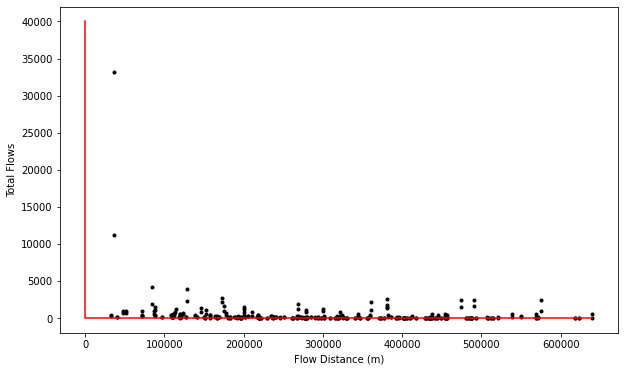

In [105]:
# flows contra distancia

# Now lets create a neat plot of the flows against dist.
f, ax = plt.subplots(1, figsize=(10,6))

# Plot data points
ax.scatter(datos_diadas['dist'], datos_diadas['personas_mig'], marker='.', color='k')

### esto solo agrega la linea rojita
# now work out the function y = x^-2 - basic inverse power.
xvals = np.geomspace(0.005, datos_diadas['dist'].max(), 1000)
yvals = np.power(xvals,-2.0)
# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# Add some labels
ax.set_ylabel("Total Flows")
ax.set_xlabel("Flow Distance (m)")


In [109]:
datos_diadas.head()

,cod_diada,depto_origen,depto_destino,personas_mig,pbi_origen,pbi_destino,dist,log_pbi_destino
0,0102,1,2,914,465848031,14214980,575727,16.469807
1,0302,3,2,74,86306492,14214980,539024,16.469807
2,0402,4,2,15,17048887,14214980,356548,16.469807
3,0502,5,2,28,43788749,14214980,571901,16.469807
4,0602,6,2,32,13023942,14214980,400851,16.469807


In [142]:
# Run a production constrained SIM using a Poisson GLM.
# We'll do this using statsmodels, and the formula approach.
# Here we're just using the 7 borough sub sample of data.
# First take logs of the relevant fields

# destsal es el salario medio en destuno
# vamos a usar el logaritmo del PBI departamental en destino
datos_diadas = datos_diadas.assign(log_pbi_destino = lambda x: np.log(x['pbi_destino']))
# logaritmo de las distancias entre díadas
datos_diadas = datos_diadas.assign(log_dist = lambda x: np.log(x['dist']))

datos_diadas.head()

,cod_diada,depto_origen,depto_destino,personas_mig,pbi_origen,pbi_destino,dist,log_pbi_destino,log_dist
0,0102,1,2,914,465848031,14214980,575727,16.469807,13.263389
1,0302,3,2,74,86306492,14214980,539024,16.469807,13.197515
2,0402,4,2,15,17048887,14214980,356548,16.469807,12.784224
3,0502,5,2,28,43788749,14214980,571901,16.469807,13.256721
4,0602,6,2,32,13023942,14214980,400851,16.469807,12.901345


In [0]:
datos_diadas.to_csv('datos_diadas.csv')

In [137]:
datos_diadas_sample = datos_diadas[(datos_diadas.depto_origen > 10) & (datos_diadas.depto_destino > 10)]
datos_diadas_sample.shape[0]

72

In [147]:

# Here we specify a model with no intercept (given by the -1 in the formula)
# In practice this means that all AiOis are estimated against an intercept of zero.
# Including the interval would mean setting the first borough in OrigNewCode to the intercept
# and interpreting all other categories in relation to that, which is less useful but would still work.

formula = "personas_mig ~ depto_origen + log_pbi_destino + log_dist -1"
prodSim = smf.glm(formula=formula, data = datos_diadas, family = sm.families.Poisson()).fit()
prodSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      339
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81274.
Date:                Sun, 24 May 2020   Deviance:                   1.6032e+05
Time:                        00:49:13   Pearson chi2:                 2.42e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
depto_origen       -0.1408      0.001   -233.458      0.000      -0.142      -0.140
log_pbi_destino     0.8653      0.001    736.389      0.000       0.863       0.868
log_dist           -0.6600      0.002   -354.515      0.000      -0.664      -0.656
===================================================================================
"""

So, what do we have from this model?

The $\alpha$ parameter related to destination attractiveness is 0.8653

The $\beta$ distance decay parameter is -0.66

The 'coef' for each origin (given here as OrigNewCode[code]) is the logged $A_{i}O_{i}$ value for that origin.